# NLP Project: Financial News Sentiment Analysis

<span style="color:magenta;font-size:20px">Autor:</span>
Junjie CHEN

<h3>Data context</h3>
<p>
This dataset contains the sentiments for financial news headlines from the perspective of a retail investor. Further details about the dataset can be found in: Malo, P., Sinha, A., Takala, P., Korhonen, P. and Wallenius, J. (2014): “Good debt or bad debt: Detecting semantic orientations in economic texts.” Journal of the American Society for Information Science and Technology.
</p>

<h3>Projet objective</h3>
<p>We want to use financial headlines to detect whether the sentiment is positive or negative.</p>

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import re
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# from gensim.models import Word2Vec
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import (
    decomposition,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    multiclass,
    naive_bayes,
    neighbors,
    svm,
    tree,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from huggingface_hub import notebook_login
from sklearn import dummy, linear_model, metrics, preprocessing
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)
from umap.umap_ import UMAP
import torch
from datasets import Dataset

In [46]:
columns=['Sentiment','text']
data = pd.read_csv('/Users/chenchenjunjie/M1_saclay/NLP/projet/Working_HNLP/Data_NLP.csv', encoding='ISO-8859-1',header=None, names=columns)

Features's Input:


In [47]:
data

,Sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


Feature Labels:

In [48]:
labers = data['Sentiment']
labers.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

<h3>Data cleaning, change all the text to lower case, and preserve only words, remove all the sign</h3>

Lowering the content:

In [49]:
# change all the text to lower case
data['text'] = data['text'].apply(lambda x: x.lower())
data['text']

0       according to gran , the company has no plans t...
1       technopolis plans to develop in stages an area...
2       the international electronic industry company ...
3       with the new production plant the company woul...
4       according to the company 's updated strategy f...
                              ...                        
4841    london marketwatch -- share prices ended lower...
4842    rinkuskiai 's beer sales fell by 6.5 per cent ...
4843    operating profit fell to eur 35.4 mn from eur ...
4844    net sales of the paper segment decreased to eu...
4845    sales in finland decreased by 10.5 % in januar...
Name: text, Length: 4846, dtype: object

In [50]:
Sentiment_count=data.groupby('Sentiment').count()
Sentiment_count

,text
Sentiment,
negative,604
neutral,2879
positive,1363


Removing punctuation signs:

In [51]:
def filter_alpha_tokens(tokens):
    # filter out non-alphabetic tokens
    return [token for token in tokens if token.isalpha()]

### Determining the total number of words per record, after having tokenized the record text:<br>
<p>Use class nltk, word_tokenize </p>

In [52]:
data['word']=data['text'].apply(lambda x: filter_alpha_tokens(word_tokenize(x)))
data['word_n'] = data['word'].apply(len)
data

,Sentiment,text,word,word_n
0,neutral,"according to gran , the company has no plans t...","[according, to, gran, the, company, has, no, p...",22
1,neutral,technopolis plans to develop in stages an area...,"[technopolis, plans, to, develop, in, stages, ...",28
2,negative,the international electronic industry company ...,"[the, international, electronic, industry, com...",33
3,positive,with the new production plant the company woul...,"[with, the, new, production, plant, the, compa...",32
4,positive,according to the company 's updated strategy f...,"[according, to, the, company, updated, strateg...",28
...,...,...,...,...
4841,negative,london marketwatch -- share prices ended lower...,"[london, marketwatch, share, prices, ended, lo...",23
4842,neutral,rinkuskiai 's beer sales fell by 6.5 per cent ...,"[rinkuskiai, beer, sales, fell, by, per, cent,...",22
4843,negative,operating profit fell to eur 35.4 mn from eur ...,"[operating, profit, fell, to, eur, mn, from, e...",17
4844,negative,net sales of the paper segment decreased to eu...,"[net, sales, of, the, paper, segment, decrease...",35


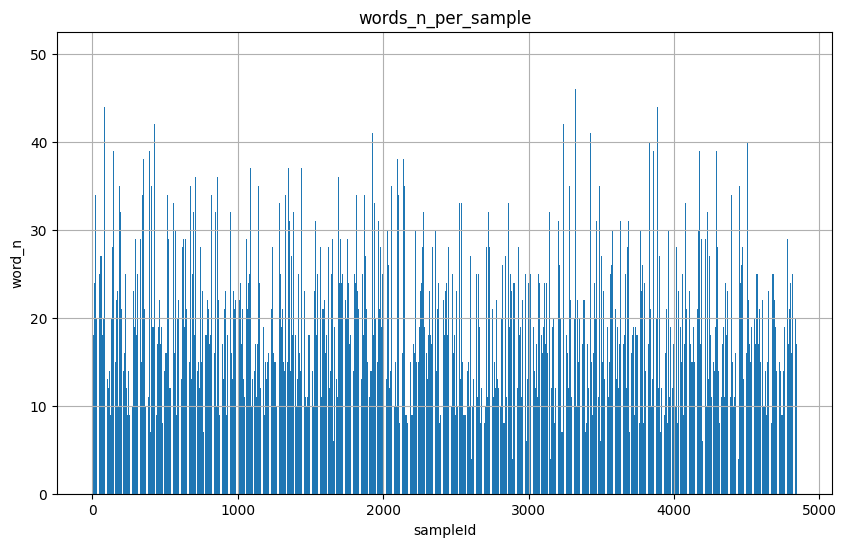

In [53]:
plt.figure(figsize=(10, 6))  
plt.bar(data.index, data['word_n']) 
plt.title('words_n_per_sample')  
plt.xlabel('sampleId')  
plt.ylabel('word_n')  
plt.grid(True)  
plt.show()  

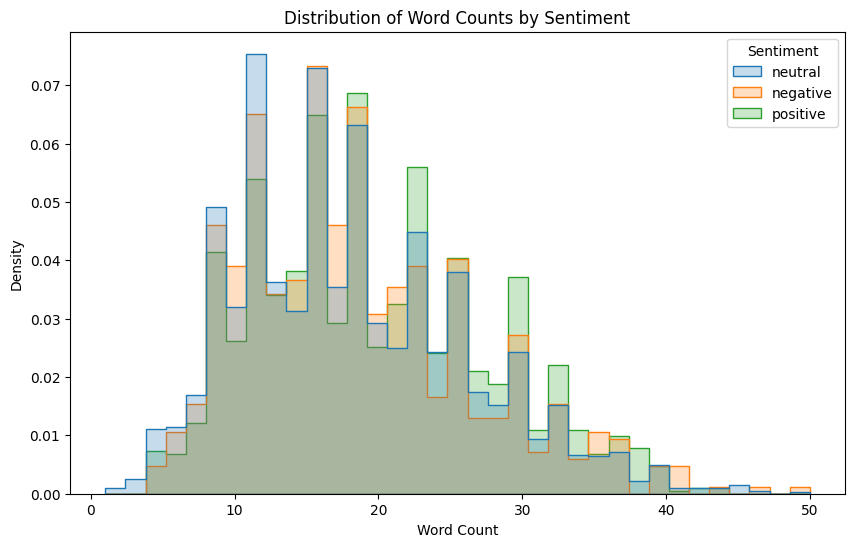

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='word_n', hue='Sentiment', element="step", stat="density", common_norm=False)
plt.title('Distribution of Word Counts by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.show()

### Count the total number of three types of samples, the total number of words, the number of words without repetition ###

In [55]:
# combine all the text for each class
grouped_text = data.groupby('Sentiment')['text'].agg(lambda texts: ' '.join(texts))

# calculate the total number of tokens in each class use word_tokenize
word_counts = grouped_text.apply(lambda x: len(filter_alpha_tokens(word_tokenize(x))))
#plot tokens in each class
words_n = grouped_text.apply(lambda x: filter_alpha_tokens(word_tokenize(x)))
# calculate the total number of unique tokens in each class
unique_word_counts = grouped_text.apply(lambda x: len(set(filter_alpha_tokens(word_tokenize(x)))))


# results combined into a single dataframe
summary_df = pd.DataFrame({
    'sample_n': Sentiment_count['text'],
    'chars_n': grouped_text.apply(len),
    'total_words': word_counts,
    'unique_words': unique_word_counts,
    'text': grouped_text,
    'words': words_n
})
summary_df


,sample_n,chars_n,total_words,unique_words,text,words
Sentiment,,,,,,
negative,604,76560,11161,1932,the international electronic industry company ...,"[the, international, electronic, industry, com..."
neutral,2879,362961,52161,6922,"according to gran , the company has no plans t...","[according, to, gran, the, company, has, no, p..."
positive,1363,186250,26763,4006,with the new production plant the company woul...,"[with, the, new, production, plant, the, compa..."


Visualizing the corpus

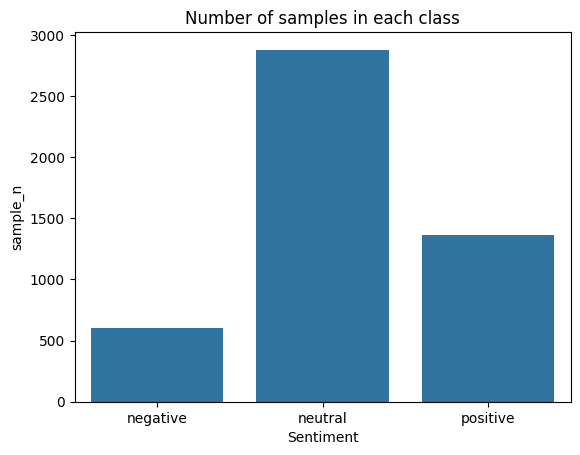

In [56]:
sns.barplot(x=summary_df.index, y=summary_df['sample_n'])
plt.title('Number of samples in each class')
plt.show()

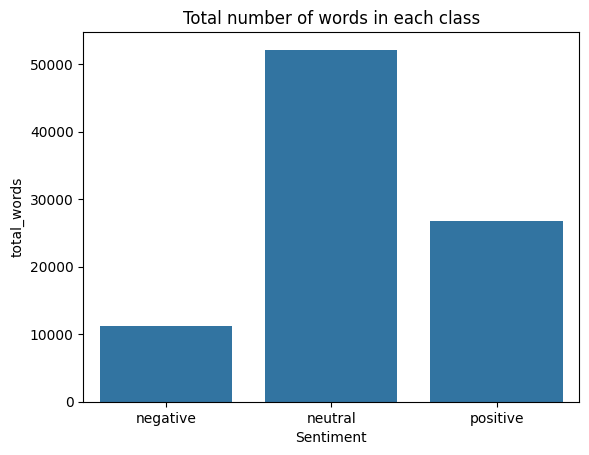

In [57]:
sns.barplot(x=summary_df.index, y=summary_df['total_words'])
plt.title('Total number of words in each class')
plt.show()

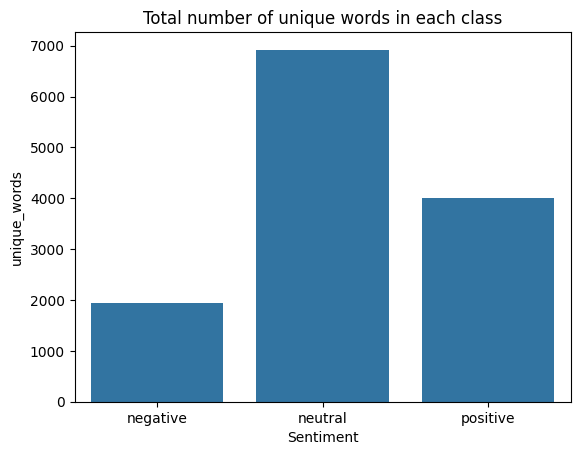

In [58]:
sns.barplot(x=summary_df.index, y=summary_df['unique_words'])
plt.title('Total number of unique words in each class')
plt.show()

### Calculate the frequency of word for each class:

In [59]:
def all_token_freq(tokens):
    #filter all the words including digits and special character
    filtered_tokens = {token : count for token,count in tokens.items() if not re.search(r"[0-9/=+\._-]", token)}
    return filtered_tokens or None

all_word_freqs_df = summary_df["words"].apply(lambda x : Counter(x)).to_frame()
all_word_freqs_df

,words
Sentiment,
negative,"{'the': 759, 'international': 4, 'electronic':..."
neutral,"{'according': 78, 'to': 1228, 'gran': 1, 'the'..."
positive,"{'with': 201, 'the': 1587, 'new': 82, 'product..."


In [60]:
def plot_top_words(filtered_tokens, sentiment, top_n=50):

    #  sort the tokens by frequency and select the top n
    top_tokens = dict(sorted(filtered_tokens.items(), key=lambda item: item[1], reverse=True)[:top_n])
        
    # plot the top tokens
    plt.figure(figsize=(10, 6))  # set the size of the plot
    plt.bar(top_tokens.keys(), top_tokens.values(), color='skyblue')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} words in {str(sentiment).capitalize()} Sentiment')
    plt.tick_params(axis='x', rotation=90)

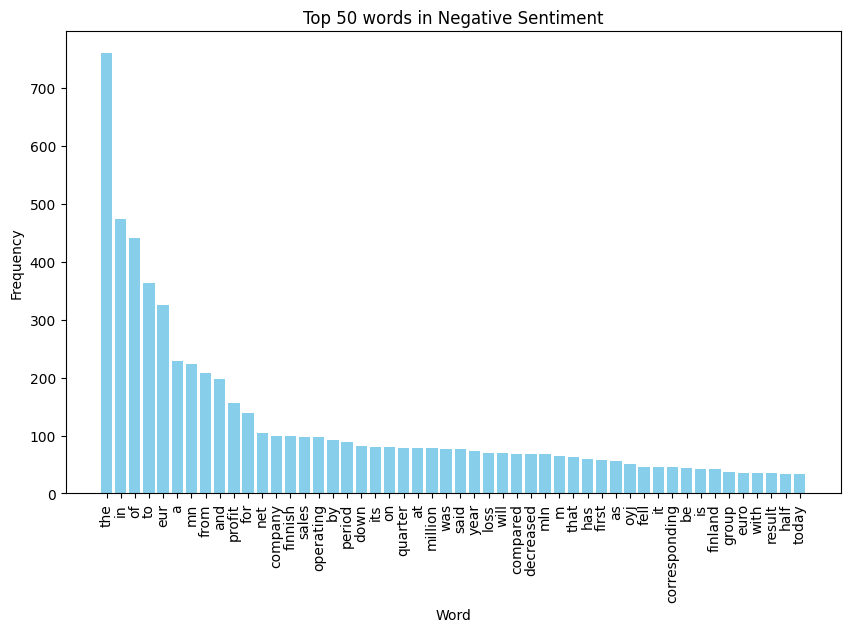

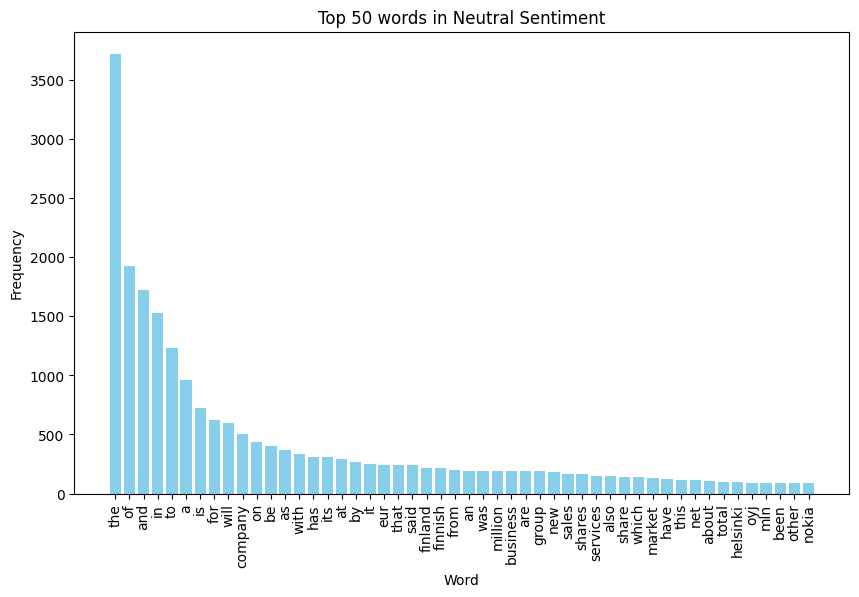

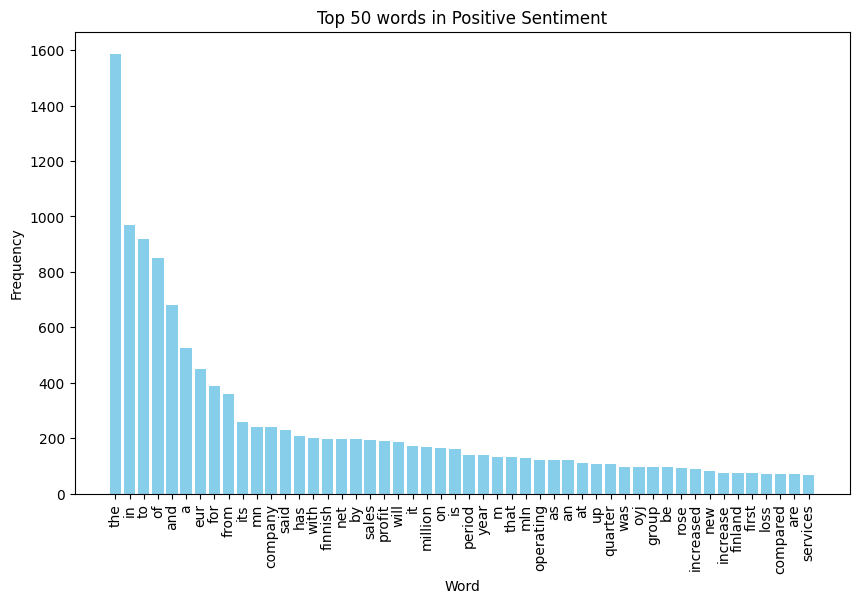

In [61]:
for index, row in all_word_freqs_df.iterrows():
    filtered_tokens = all_token_freq(row['words'])
    plot_top_words(filtered_tokens, index)

# we find word 'decrease' in negative sentiment, and word 'increase' is the most frequent word in positive sentiment

The richness of words in each category was analyzed as the sample increased

In [62]:
def batch_counts(text,maxlen,hop):
    counters = [Counter()]
    words = word_tokenize(text)
    for i in range(0, maxlen, hop):
        batch_words = words[:i + hop]
        counters.append(Counter(batch_words))
    # return the counts for each batch
    return [len(cntr) for cntr in counters]

Sentiment
negative    [0, 73, 123, 169, 201, 220, 239, 255, 287, 323...
neutral     [0, 70, 131, 182, 225, 268, 311, 356, 395, 429...
positive    [0, 66, 103, 157, 195, 231, 271, 302, 337, 356...
Name: text, dtype: object


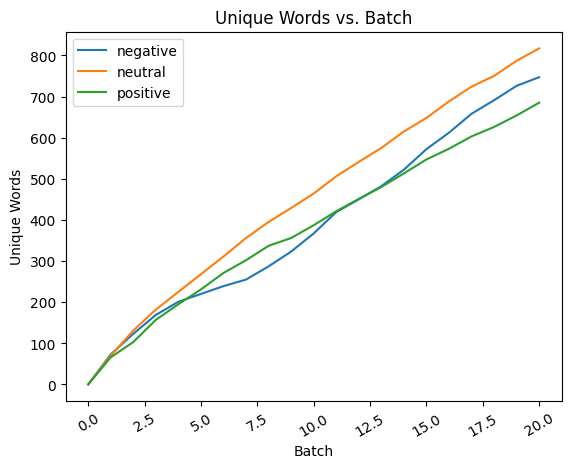

In [63]:
HOP = 100
batch_counters = summary_df.text.map(
    lambda x: batch_counts(x,summary_df.unique_words.min(),hop=HOP)
)
print(batch_counters)
batch_counters_df = pd.DataFrame(
    batch_counters.tolist(),
    index=summary_df.index
)
batch_counters_df.T.plot(legend=False)
plt.xticks(rotation=30)
plt.xlabel('Batch')
plt.ylabel('Unique Words')
plt.title('Unique Words vs. Batch')
plt.legend()
plt.show()


## Boxplot the number of words per class sentiment

<Figure size 1000x600 with 0 Axes>

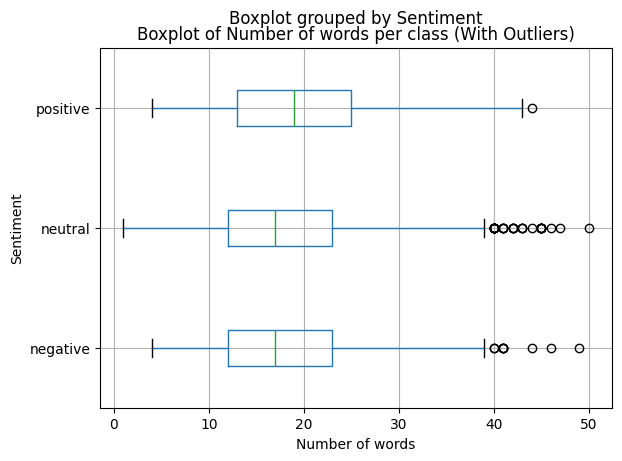

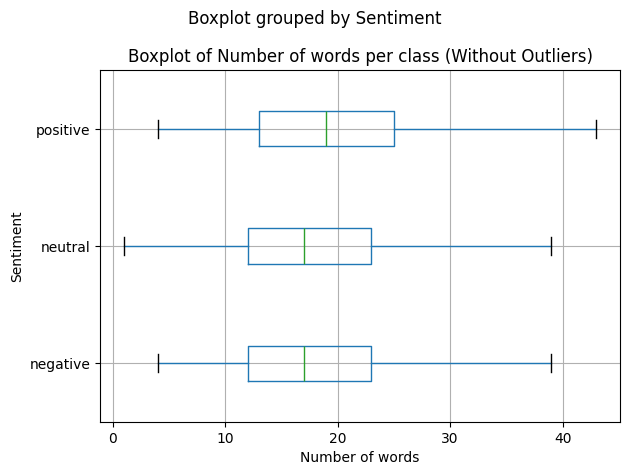

In [64]:
# Draw a box diagram containing outliers
plt.figure(figsize=(10, 6))

data.boxplot(column='word_n', by='Sentiment',vert=False, showfliers=True)
plt.title('Boxplot of Number of words per class (With Outliers)')
plt.xlabel('Number of words')

# Draw a box diagram that does not contain outliers

data.boxplot(column='word_n',by='Sentiment',vert=False, showfliers=False)
plt.title('Boxplot of Number of words per class (Without Outliers)')
plt.xlabel('Number of words')

plt.tight_layout()
plt.show()

# Explanation BoxPlots

The boxplot visualization is grouped by sentiment categories: positive, neutral, and negative. The purpose of the boxplot is to show the distribution of the number of words per sentiment class in a dataset. Here's a breakdown of the key components:

1. **Sentiments**: The y-axis represents different sentiment categories. There are three categories in this case: positive, neutral, and negative.

2. **Number of Words**: The x-axis shows the number of words. This indicates the word count in the text entries corresponding to each sentiment category.

3. **Boxplot Elements**:
   - The **box** in each boxplot represents the interquartile range (IQR), which is the middle 50% of the data for that sentiment.
   - The **horizontal line** inside the box marks the median of the data, which is the middle value.
   - The **whiskers** (vertical lines extending from the box) indicate the range of the data, excluding outliers. Typically, they extend to 1.5 times the IQR above and below the box.
   - The **dots** outside the whiskers are **outliers**. These are data points that fall outside the range defined by the whiskers.

4. **Title**: The title "Boxplot of Number of words per class (With Outliers)" provides an overview of what the chart represents.

5. **Outliers**: The presence of outliers is especially noticeable for the neutral sentiment, where several points lie significantly above the upper whisker.

The plot provides a visual summary of the central tendency and dispersion of the word counts for each sentiment category and highlights potential outliers in the dataset.

## Confusion Matrix

In [65]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = metrics.confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
labels = [ 'negative','neutral', 'positive']

# Base Model 1: Count Vectorizer 

### Firstly, we use CountVectorizer with a basic Machine learning algorithm such as the Logistic Regression for prediction.

## Data for CountVectorizer

In [66]:
data

,Sentiment,text,word,word_n
0,neutral,"according to gran , the company has no plans t...","[according, to, gran, the, company, has, no, p...",22
1,neutral,technopolis plans to develop in stages an area...,"[technopolis, plans, to, develop, in, stages, ...",28
2,negative,the international electronic industry company ...,"[the, international, electronic, industry, com...",33
3,positive,with the new production plant the company woul...,"[with, the, new, production, plant, the, compa...",32
4,positive,according to the company 's updated strategy f...,"[according, to, the, company, updated, strateg...",28
...,...,...,...,...
4841,negative,london marketwatch -- share prices ended lower...,"[london, marketwatch, share, prices, ended, lo...",23
4842,neutral,rinkuskiai 's beer sales fell by 6.5 per cent ...,"[rinkuskiai, beer, sales, fell, by, per, cent,...",22
4843,negative,operating profit fell to eur 35.4 mn from eur ...,"[operating, profit, fell, to, eur, mn, from, e...",17
4844,negative,net sales of the paper segment decreased to eu...,"[net, sales, of, the, paper, segment, decrease...",35


## Labels for CountVectorizer

In [67]:
ys = data['Sentiment']
ys

0        neutral
1        neutral
2       negative
3       positive
4       positive
          ...   
4841    negative
4842     neutral
4843    negative
4844    negative
4845    negative
Name: Sentiment, Length: 4846, dtype: object

## Model Instantiation: CountVectorizer

In [68]:
vectorizer = CountVectorizer()

# Convert the array of words into a single complete block of string 
text_data = [" ".join(text) for text in data['word']]

# Convert the text data into a matrix of token counts
xs = vectorizer.fit_transform(text_data)

# All features
vectorizer.get_feature_names_out()

array(['aaland', 'aalborg', 'aalto', ..., 'zoo', 'zte', 'zu'],
      dtype=object)

In [69]:
# Converting into a DataFrame for visualization
cv_df = pd.DataFrame(xs.toarray(), columns=vectorizer.get_feature_names_out())

# Setting the index
cv_df.set_index(data.index, inplace=True)

cv_df

,aaland,aalborg,aalto,aaltonen,aaron,aava,aazhang,ab,abb,abbott,...,zero,zgody,zinc,zip,zloty,zoltan,zone,zoo,zte,zu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4841,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4842,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4843,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4844,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train & Test Split

In [70]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.2, random_state=0, shuffle=True
)
print("Train Shape:", train_xs.shape)
print("Test Shape:",test_xs.shape)

Train Shape: (3876, 8657)
Test Shape: (970, 8657)


## Training Process

Logistic Regression Accuracy: 0.77
Classification Report:

              precision    recall  f1-score   support

    negative       0.79      0.51      0.62       128
     neutral       0.78      0.90      0.84       575
    positive       0.73      0.62      0.67       267

    accuracy                           0.77       970
   macro avg       0.77      0.68      0.71       970
weighted avg       0.77      0.77      0.76       970



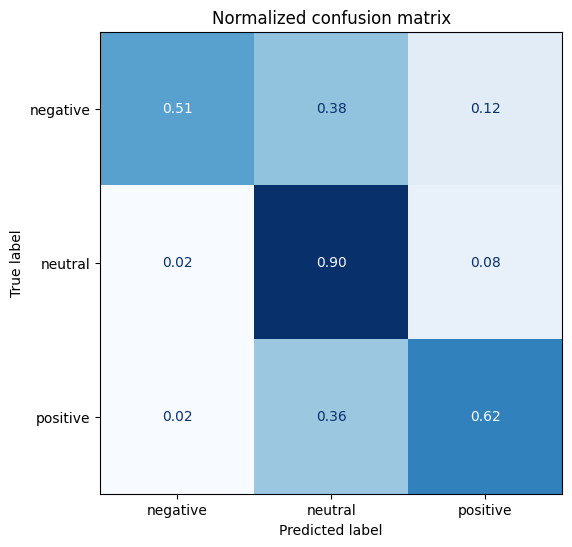

In [71]:
# This part is about the vectorization with basic machine learning model
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(train_xs, train_ys)

pred_ys = logistic_regression_model.predict(test_xs)
accuracy = logistic_regression_model.score(test_xs, test_ys)
print(f'Logistic Regression Accuracy: {accuracy:.2f}')

print("Classification Report:\n")
print(classification_report(test_ys, pred_ys))

# Confusion Matrix
plot_confusion_matrix(pred_ys, test_ys, labels)

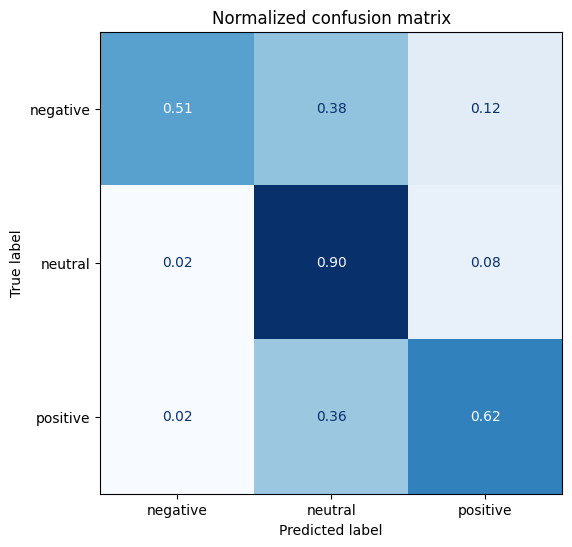

In [72]:
plot_confusion_matrix(pred_ys, test_ys, labels)

# Base Model 2: TF-IDF Vectorizer

### Secondly, we use TF-IDF with a basic Machine learning algorithm such as the Logistic Regression for prediction.

## Model Instantiation: TF-IDF Vectorizer 

In [73]:
# This part is about the vectorization with basic machine learning model
transformer = TfidfVectorizer()

# Converting the text data into a matrix of token counts 
xs_tf = transformer.fit_transform(text_data).toarray()

# Converting to a DataFrame for visualization
tf_idf = pd.DataFrame(xs_tf, index=data.index, columns=transformer.get_feature_names_out()) # create a dataframe from the tf-idf matrix


tf_idf

,aaland,aalborg,aalto,aaltonen,aaron,aava,aazhang,ab,abb,abbott,...,zero,zgody,zinc,zip,zloty,zoltan,zone,zoo,zte,zu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train & Test Split

In [74]:
train_x_tf, test_x_tf, train_ys_tf, test_ys_tf = train_test_split(
    xs_tf, ys, test_size=0.2, random_state=0, shuffle=True
)
print("Train Shape:", train_x_tf.shape)
print("Test Shape:",test_x_tf.shape)

Train Shape: (3876, 8657)
Test Shape: (970, 8657)


## Training Process

TfidfVectorizer Accuracy: 0.7618556701030927
TfidfVectorizer Classification Report:

              precision    recall  f1-score   support

    negative       0.85      0.39      0.53       128
     neutral       0.75      0.95      0.84       575
    positive       0.79      0.53      0.63       267

    accuracy                           0.76       970
   macro avg       0.80      0.62      0.67       970
weighted avg       0.77      0.76      0.74       970



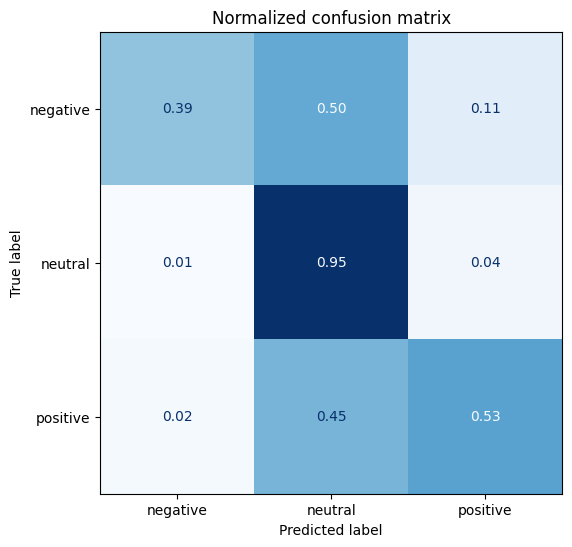

In [75]:
# Create a logistic regression model
clf_tfidf = LogisticRegression(max_iter=1000)

# Train the model
clf_tfidf.fit(train_x_tf, train_ys_tf)

# Predict the test data
pred_ys_tf = clf_tfidf.predict(test_x_tf)

print("TfidfVectorizer Accuracy:", accuracy_score(test_ys_tf, pred_ys_tf))

print("TfidfVectorizer Classification Report:\n")

print(classification_report(test_ys_tf, pred_ys_tf))

# Confusion matrix
plot_confusion_matrix(pred_ys_tf, test_ys_tf, labels)

# Model Base 3: WORD2VEC

### In third position, we use Word2vec with, once again, Logistic Regression.

### Extract features using Word2Vec embeddings: We'll use the Gensim library to access pre-trained Word2Vec embeddings to convert the text into vectors.

### Train a basic ML model: We'll train a Logistic Regression model, which is a good starting point for classification tasks.

In [39]:
# Vectorization of data with Word2Vec
model_w2v = Word2Vec(sentences=data['text'], vector_size=100, window=5, min_count=1, workers=4)

# Obtain the word vectors embeddings for each sample
def document_vector(word_list):
    # Remove out-of-vocabulary words
    word_list = [word for word in word_list if word in model_w2v.wv.index_to_key]
    if len(word_list) == 0:
        return np.zeros(100)
    # Calculate the mean of the word vectors
    return np.mean(model_w2v.wv[word_list], axis=0)

# We apply the function to the text column
data['Vec'] = data['text'].apply(document_vector)

# Vector embeddings
X_wd2 = np.array(list(data['Vec'])) # eigenvector

# Labels
y_wd2 = data['Sentiment'] # target

## Train & Test Split

In [40]:
# Split dataset into training and testing set
X_train_wd2, X_test_wd2, y_train_wd2, y_test_wd2 = train_test_split(X_wd2, y_wd2, test_size=0.2, random_state=42)
print("Train Shape:", X_train_wd2.shape)
print("Test Shape:",X_test_wd2.shape)

Train Shape: (3876, 100)
Test Shape: (970, 100)


              precision    recall  f1-score   support

    negative       0.36      0.05      0.08       110
     neutral       0.63      0.98      0.77       571
    positive       0.59      0.15      0.24       289

    accuracy                           0.63       970
   macro avg       0.53      0.39      0.36       970
weighted avg       0.59      0.63      0.53       970



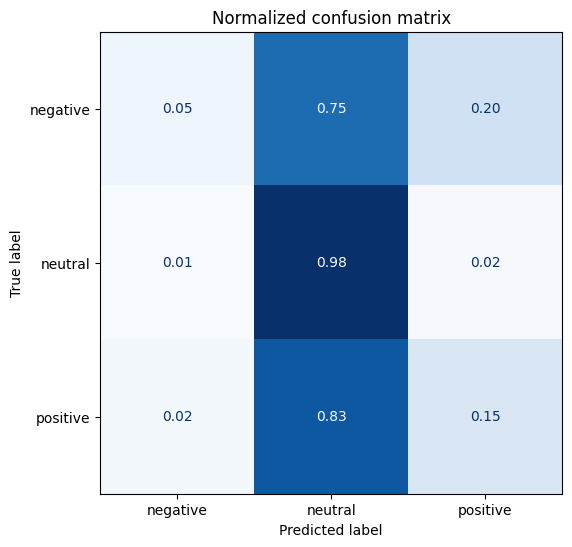

In [41]:
# We use Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_wd2, y_train_wd2)

# Prediction and evaluation of the model
y_pred_wd2 = model.predict(X_test_wd2)
print(classification_report(y_test_wd2, y_pred_wd2 ))

# Confusion matrix
plot_confusion_matrix(y_pred_wd2, y_test_wd2, labels)

# Base Model 4: DOC2CV

### Lastly, we use the DOC2CV model and the Logistic Regression

              precision    recall  f1-score   support

    negative       0.15      0.02      0.03       110
     neutral       0.63      0.96      0.76       571
    positive       0.44      0.12      0.19       289

    accuracy                           0.61       970
   macro avg       0.41      0.37      0.33       970
weighted avg       0.52      0.61      0.51       970



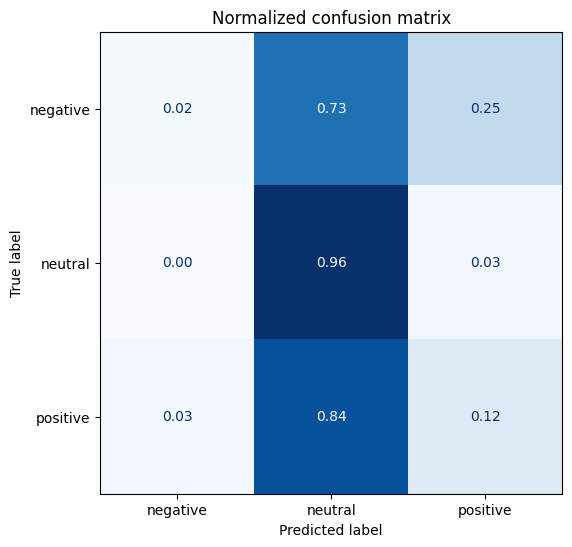

In [43]:

# Train a Doc2Vec model

# Gensim class pairs a document with a tag. The documents are tagged with a unique identifier i, which is simply the index of the document in the dataset.
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['word'])]

# Model Instantiation of Doc2Vec
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

# Extract the vectors
def vector_for_document(model, doc):
    return model.infer_vector(doc)

# Vector embeddings and corresponding labels
x_doc2 = np.array([vector_for_document(model, doc) for doc in data['word']])
y_doc2 = data['Sentiment'].values

# Train & Test Split and training the classifier
X_train_doc2, X_test_doc2, y_train_doc2, y_test_doc2 = train_test_split(x_doc2, y_doc2, test_size=0.2, random_state=42)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_doc2, y_train_doc2)

# Prediction and evaluation of the model
y_pred_doc2 = classifier.predict(X_test_doc2)
print(classification_report(y_test_doc2, y_pred_doc2))
plot_confusion_matrix(y_pred_doc2, y_test_doc2, labels)

# Conclusion for the baseline approach:

1. CountVectorizer = 0.77

2. TF-IDF Vectorizer = 0.76

3. Word2vec = 0.64 

4. Doc2CV = 0.60


# First Transformer Model: DistilBERT

### This part, we begin to use a more expressive model with Transformers as feature extraction only and the same basic ML algorithms (Logistic Regression) - DistilBERT Model

To grasp the general idea of the process let's consider the following example:

1. **Tokenization**
   - The string is split into tokens. Tokens are the words or subwords that the model has been trained to understand.
   - "The quick brown fox jumps over the lazy dog"
   - For our example, assuming a simple tokenizer, the tokens might be: ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]

2. **Token Encodings**
   - Each token is mapped to a unique integer called a token ID. This is done using the model's vocabulary.
   - The tokens might be mapped like this: [101, 12345, 23456, 34567, 45678, 56789, 101, 67890, 78901].1, 12345, 23456, 34567, 45678, 56789, 101, 67890, 78901]

3. **Token Embeddings**
   - Each token ID is then converted into a high-dimensional vector called an embedding. This embedding is learned during the model's pre-training and captures semantic information about the token.
   - The token embeddings would be vectors, for example: [E(The), E(quick), E(brown), ..., E(dog)], where E(x) is the embedding of token x.

4. **Encoder Stack Processing**
   - The token embeddings are passed through a series of transformer encoder layers. Each layer applies self-attention, allowing the model to consider other words in the sentence when understanding each word.
   - The self-attention mechanism helps to understand the context. For example, it helps the model learn that "fox" is an animal in this sentence because of its relation to "jumps" and "dog".

5. **Hidden States Output**
   - After going through the encoder layers, we get hidden states. These are updated embeddings that incorporate the context of each token relative to all the others in the sentence.
   - The hidden states are the output of the encoder stack, which contain rich contextual information.
   - The updated embedding would be [Contextualized Embedding of The, ..., Contextualized Embedding of dog].

6. **Classification Head**
   - For classification tasks, the hidden state corresponding to a special token (like [CLS] in BERT) is typically used. This state is supposed to aggregate the information of the whole sentence.
   - This [CLS] token's hidden state is passed through a classification layer (or "head") that has been fine-tuned for a specific task, such as sentiment analysis.
   - Aggregated Context (from H([CLS]))

7. **Predictions**
   - Finally, the classification head outputs a probability distribution over potential classes (e.g., positive, neutral, negative for sentiment analysis).
   - The model might predict that the sentence has a positive sentiment based on the learned associations during training.
   - Sentiment: Positive/Negative/Neutral

In [76]:
## Using gpu acceleration
print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")

True
True


## Label Encoding

In [77]:
# Data
df = data[['Sentiment','text']]

# Encoding the labels to numerical values: 1, 0, -1
df['Sentiment'] = df['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})
df

/var/folders/tt/pf5xh4vs14v9h68lqh4py2s00000gn/T/ipykernel_65397/1119543588.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})


,Sentiment,text
0,0,"according to gran , the company has no plans t..."
1,0,technopolis plans to develop in stages an area...
2,-1,the international electronic industry company ...
3,1,with the new production plant the company woul...
4,1,according to the company 's updated strategy f...
...,...,...
4841,-1,london marketwatch -- share prices ended lower...
4842,0,rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,-1,operating profit fell to eur 35.4 mn from eur ...
4844,-1,net sales of the paper segment decreased to eu...


In [78]:
# Load the pre-trained model DistilBERT and the Tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move the model to the device
model.to(device)

# Converting data
texts = data['text'].tolist()
labels = data['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1}).tolist()


## Data

In [79]:
texts[:5]

['according to gran , the company has no plans to move all production to russia , although that is where the company is growing .',
 'technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .',
 'the international electronic industry company elcoteq has laid off tens of employees from its tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily postimees reported .',
 'with the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .',
 "according to the company 's updated strategy for the years 2009-2012 , basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales ."]

## Labels

In [80]:
labels[:5]

[0, 0, -1, 1, 1]

In [81]:

# We use GPU boost to extract features
def extract_features(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=50, return_tensors="pt")
    inputs = inputs.to(device)  # Move the input tensors to the device
    with torch.no_grad():
        outputs = model(**inputs)
    # Return the first token of the last hidden state
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

#features = extract_features(texts)

In [82]:
# Word segmentation is performed on the data set
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=50)
tokenized_data = df.apply(tokenize_function, axis=1)
tokenized_df = pd.DataFrame(tokenized_data.tolist())  # if result is a DataFrame
tokenized_df[['label','text']] = df[['Sentiment','text']]

tokenized_df

,attention_mask,input_ids,label,text
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2429, 2000, 12604, 1010, 1996, 2194, 203...",0,"according to gran , the company has no plans t..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 21416, 17699, 3488, 2000, 4503, 1999, 57...",0,technopolis plans to develop in stages an area...
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1996, 2248, 4816, 3068, 2194, 3449, 1980...",-1,the international electronic industry company ...
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2007, 1996, 2047, 2537, 3269, 1996, 2194...",1,with the new production plant the company woul...
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2429, 2000, 1996, 2194, 1005, 1055, 7172...",1,according to the company 's updated strategy f...
...,...,...,...,...
4841,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2414, 3006, 18866, 1011, 1011, 3745, 759...",-1,london marketwatch -- share prices ended lower...
4842,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 18416, 2271, 21128, 2072, 1005, 1055, 54...",0,rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 4082, 5618, 3062, 2000, 7327, 2099, 3486...",-1,operating profit fell to eur 35.4 mn from eur ...
4844,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 5658, 4341, 1997, 1996, 3259, 6903, 1054...",-1,net sales of the paper segment decreased to eu...


## Explanation of DataFrame:

1. input_ids: 

This column contains lists of numerical IDs, with each number representing a specific word in a pre-defined vocabulary. The model uses these IDs to look up the embeddings for each word. These IDs are generated by tokenizing the text, which involves splitting it into words or subwords and then converting each token into its corresponding ID as per the model's vocabulary.

2. attention_mask: 

This column is composed of lists of 1's and 0's. It tells the model which tokens should be paid attention to and which should not. In the case of BERT and similar transformer models, this is necessary because they use fixed-length input sequences. If a sentence is shorter than the maximum sequence length, it needs to be padded with extra tokens (usually represented by the ID 0). The attention mask ensures that the model doesn't consider these padding tokens when processing the input. A value of 1 indicates that the token at that position should be used, while a 0 indicates a padding token that should not be factored into the model's interpretations. The value 1 across the entire attention_mask for all entries, as seen in your image, suggests that all tokens should be considered by the model.

## Hidden States Extraction

In [83]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {
        k: torch.tensor(v).to(device) for k, v in batch.items()
        if k in tokenizer.model_input_names
    }
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

## DataFrame to DatasetDict

In [84]:
# Convert the dataframe to a dataset of huggingface which seems like a dictionary
emotions = Dataset.from_pandas(tokenized_df)

# Split the dataset into training and testing set
emotions_data = emotions.train_test_split(test_size=0.2)
emotions_data

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 3876
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 970
    })
})

In [85]:
emotions_hidden = emotions_data.map(extract_hidden_states, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [86]:
emotions_hidden['train'].column_names

['attention_mask', 'hidden_state', 'input_ids', 'label', 'text']

## Train & Test Split

In [111]:
train_xs = np.array(emotions_hidden["train"]["hidden_state"])
test_xs = np.array(emotions_hidden["test"]["hidden_state"])
train_ys = np.array(emotions_hidden["train"]["label"])
test_ys = np.array(emotions_hidden["test"]["label"])

print("Train Shape:", train_xs.shape)
print("Test Shape:", test_xs.shape)

Train Shape: (3876, 768)
Test Shape: (970, 768)


## UMAP - Uniform Manifold Approximation and Projection

We consider the following steps to visualize the data in a 2D space.

1. Label Mapping: A dictionary named label_mapping is created to convert sentiment labels from string format to numerical format. Positive sentiment is mapped to 1, neutral to 0, and negative to -1.

2. Feature Scaling: The features in train_xs are scaled to a range of [0,1] using MinMax scaling. This scaling ensures that all features contribute equally to the model's performance by normalizing the range of feature values.

3. UMAP Initialization and Fitting: UMAP (Uniform Manifold Approximation and Projection) is an algorithm used for dimensionality reduction. It's initialized with 2 components (meaning the high-dimensional data will be mapped to a 2D space) and uses cosine similarity as the metric to measure distance between points. Then, it is fitted to the scaled training features scaled_xs, effectively learning the low-dimensional representation of the data.

4. Creating a DataFrame of 2D Embeddings: After UMAP has transformed the data, the low-dimensional embeddings are put into a pandas DataFrame named df_emb with two columns, "X" and "Y", representing the coordinates in the 2D space.

5. Adding Labels to the DataFrame: The sentiment labels (train_ys) are added to the DataFrame df_emb under the column "label". These labels correspond to the original sentiment labels of the training data.


In [112]:
label_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}

# Scale features to [0,1] range
scaled_xs = preprocessing.MinMaxScaler().fit_transform(train_xs)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(scaled_xs)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = train_ys
df_emb.head()

,X,Y,label
0,13.855760,3.711308,0
1,15.086978,5.523126,1
2,12.879094,3.777655,0
3,12.216313,6.522005,0
4,8.830297,3.221908,0


## Visualization of Sentiment Regions

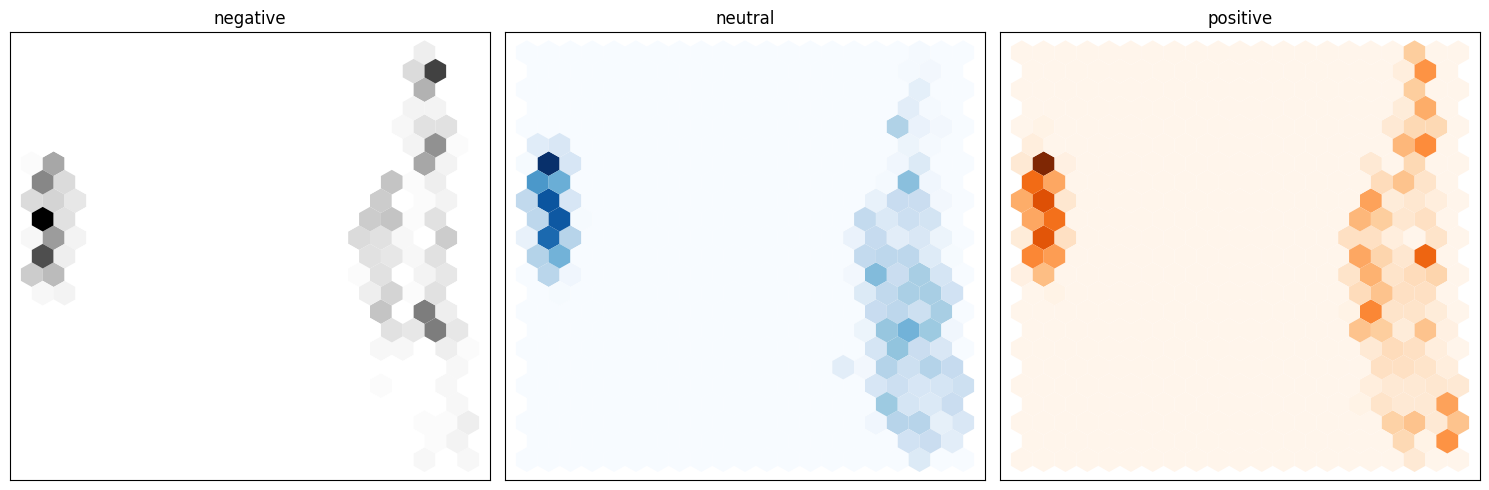

In [89]:
labels = [ 'negative','neutral', 'positive']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges"]

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i-1}")
    axes[i].hexbin(
        df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,)
    )
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

## Analysis of Sentiment Regions

This kind of visualization helps to understand the distribution and density of data points in a 2D space, which is often the result after applying a dimensionality reduction technique like UMAP.

From the images, we interpret the follwoing information:

- Negative (Leftmost Plot): Data points representing the negative sentiment are plotted in hexagonal bins, with darker hexagons indicating a higher density of points in that area. The clustering of dark hexagons might suggest that negative sentiments are more densely packed in certain regions of the space, indicating similarity among them.

- Neutral (Center Plot): The middle plot shows the neutral sentiment data points with a similar hexagonal binning approach. The color intensity here is used to represent density, with darker colors again indicating higher density. The distribution of neutral sentiments may appear more spread out or less dense than negative sentiments.

- Positive (Rightmost Plot): The plot on the right shows the positive sentiment data points. As with the other plots, the color saturation indicates the concentration of data points, with darker hexagons reflecting higher densities.

Overall, these plots allow us to observe where data points are concentrated and how they are distributed across different sentiment categories. If data points from different sentiments are well separated into distinct clusters, it would imply that the dimensionality reduction has preserved the sentiment distinctions well in the 2D space.

If there's overlap, it might suggest that some sentiments are not as easily distinguishable based on the data provided. This visualization is helpful for identifying patterns that might not be apparent in high-dimensional space.

## Logistic regression prediction with DistilBERT 

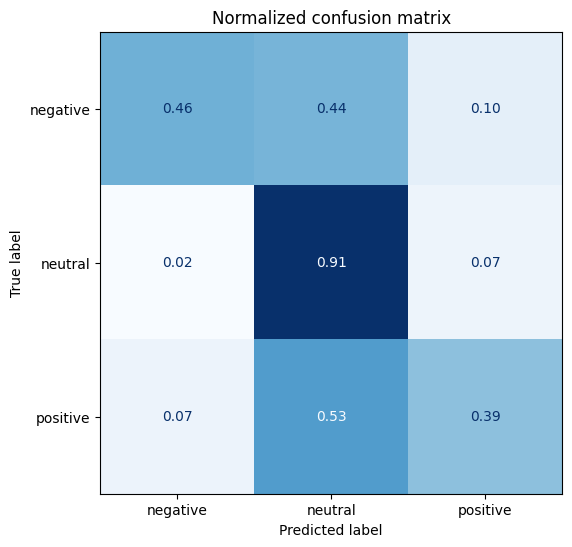

              precision    recall  f1-score   support

          -1       0.62      0.46      0.53       116
           0       0.73      0.91      0.81       577
           1       0.69      0.39      0.50       277

    accuracy                           0.71       970
   macro avg       0.68      0.59      0.61       970
weighted avg       0.70      0.71      0.69       970



In [113]:
# Training of the Model
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_xs, train_ys)

# Preiction and Evaluation of the model
pred_ys = classifier.predict(test_xs)
plot_confusion_matrix(pred_ys, test_ys, labels)
print(classification_report(test_ys, pred_ys))


## Dummy Classififier VS DistilBERT

In [91]:
dummy_clf = dummy.DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_xs, train_ys)
dummy_clf.score(test_xs,test_ys)

0.5948453608247423

# Second Transformer Model: DistilBERT Fine-Tuned

### Third part : Use a more comprehensive approach with a Transformers model that you fine-tuned on our data.

Before jumpinto into straight to the coding solution, let's understand what we are doing.

- In the previous feature extraction approach, we only used the DistilBERT model to transform our text data into a rich, numerical form (embeddings) and then applied a separate machine learning model (Logistic Regression) to those features to make predictions.

- Fine-tuning, on the other hand, is like customizing the DistilBERT model to our specific task. We start with the pre-trained model, which already knows a lot about language from its initial training (HuggingFace), and we continue the training process so that it gets better at our particular classification task (like distinguishing between positive, neutral, and negative sentiments). 

- This involves adjusting the model's internal parameters to reduce errors in prediction for our specific dataset. The model's classification head, which we add on top, is also trained simultaneously, learning to make predictions based on the refined representations that DistilBERT creates.

## Initializing a Pretrained Model for Classification

To start, we require a pretrained model, similar to DistilBERT, which we utilized in the feature extraction method. However, this time we select AutoModelForSequenceClassification instead of AutoModel. This variant includes a classification layer atop the pretrained network, designed to be fine-tuned alongside the underlying model. We must define the count of distinct labels our model is expected to classify (for us, that's three), as this determines the output size of the final classification layer:

In [114]:
num_labels = 3
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels
).to(device)

## Defining the performance metrics: Accuracy & F1-Score

- To monitor metrics during training, we need to define a compute_metrics() function for the Trainer. 

- This function receives an EvalPrediction object (which is a named tuple with predictions and label_ids attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the  F1-score and the accuracy of the model as follows:

In [93]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = metrics.f1_score(labels, preds, average="weighted")
    acc = metrics.accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

## Fine-tuning the Model DistilBERT

### 1. Trainer - Hyperparameters

The following cell will include the code that allows us to "customize" the training for the already pre-trained model DistilBERT from HuggingFace.

- **Batch Size**: `batch_size = 30` sets the number of samples that will be passed through the model at once during training. A batch size of 30 means that 30 examples from the training data are used to update the model's weights each step.

- **Logging Steps**: `logging_steps` is calculated by dividing the total number of training examples by the `batch_size`. It determines how often to log training progress information. For example, if you have 300 training examples, `logging_steps` would be 10, meaning that progress will be logged after every 10 batches.

- **Model Name**: `model_name2` is a string that adds "-Insanity" to the original `model_name`.

- **Training Arguments**: `training_args` is an instance of `TrainingArguments`, which sets various parameters for training:

  - `output_dir`: The directory where the training outputs (like model checkpoints) will be saved.

  - `num_train_epochs`: The total number of passes through the entire training dataset. Here, it's set to 2, meaning the entire dataset will be used twice to train the model.
  
  - `learning_rate`: The rate at which the model learns during training. A smaller learning rate means the model will learn more slowly, but it can help the model reach better performance.
  
  - `per_device_train_batch_size` and `per_device_eval_batch_size`: These set the batch size for both training and evaluation, ensuring consistency in batch sizes across different devices if using multiple GPUs or TPUs.
  
  - `weight_decay`: This is a regularization parameter that helps prevent the model from overfitting to the training data by penalizing large weights.
  
  - `evaluation_strategy`: Determines how often to evaluate the model. Setting it to "epoch" means the model will be evaluated at the end of each epoch.
  
  - `disable_tqdm`: If set to `False`, progress bars will be shown during training.
  
  - `logging_steps`: As calculated earlier, it sets the frequency of logging training progress.
  
  - `push_to_hub`: If set to `True`, the model would be uploaded to the Hugging Face Model Hub. It's set to `False` here, meaning no upload will occur.
  
  - `log_level`: Sets the logging level to "error", meaning only error messages will be logged, reducing the amount of log output.

This configuration is used to fine-tune the model in a controlled manner, monitoring its progress and ensuring it's learning at a steady rate while avoiding overfitting.

In [107]:
# Batch Size
batch_size = 30

# Total number of steps to train the pre-trained model
logging_steps = len(emotions_data['train']) // batch_size

# Model 
model_name2 = f"{model_name}_System_analyse_sentiment"
training_args = TrainingArguments(
    output_dir=f"./{model_name2}",
    num_train_epochs=2,
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,  # True
    log_level="error",
)

## Labels Adjustment

Previously we defined that our 3 possible classes were labeled as follows: -

- 1: Positive
- 0: Neutral
- -1: Negative

However, for the Trainer Instance, we are forced to change this labeling to only positive labels due to the internal restrictions, therefore to do the mentioned change, we define a function called adjust_labels and we scale the values to 0,1 and 2.

In [109]:
def adjust_labels(example):
    example['label'] += 1
    return example

emotions_data['train'] = emotions_data['train'].map(adjust_labels)
emotions_data['test'] = emotions_data['test'].map(adjust_labels)

  0%|          | 0/3876 [00:00<?, ?ex/s]

  0%|          | 0/970 [00:00<?, ?ex/s]

### 2. Trainer - Training & Test Dataset

In [116]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_data["train"],
    eval_dataset=emotions_data["test"],
    tokenizer=tokenizer,
)
trainer.train()
# save the model and the tokenizer
model.save_pretrained(f"./{model_name2}")
tokenizer.save_pretrained(f"./{model_name2}")

TypeError: cannot unpack non-iterable AdamW object

In [97]:
preds_output = trainer.predict(emotions_data["test"])

  0%|          | 0/33 [00:00<?, ?it/s]

In [98]:
preds_output.metrics

{'test_loss': 0.4079994559288025,
 'test_accuracy': 0.8422680412371134,
 'test_f1': 0.8425896761609213,
 'test_runtime': 7.7615,
 'test_samples_per_second': 124.976,
 'test_steps_per_second': 4.252}

In [99]:
y_preds = np.argmax(preds_output.predictions, axis=1)

## Confusion Matrix

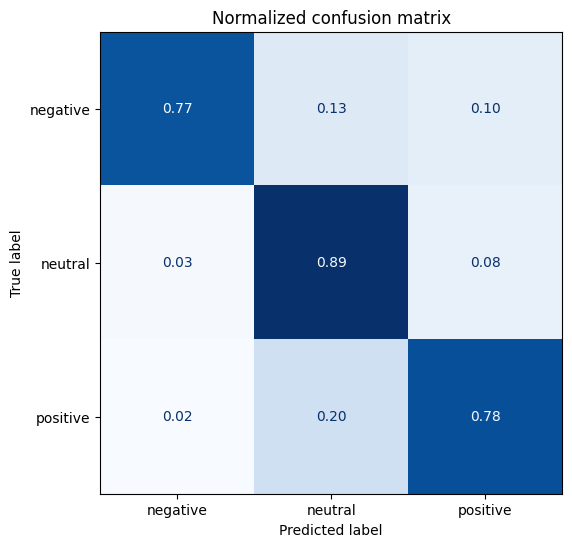

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       116
           1       0.89      0.88      0.88       577
           2       0.78      0.78      0.78       277

    accuracy                           0.84       970
   macro avg       0.81      0.83      0.82       970
weighted avg       0.84      0.84      0.84       970



In [100]:
plot_confusion_matrix(emotions_data["test"]['label'], y_preds, labels)
print(classification_report(emotions_data["test"]['label'], y_preds))

In [101]:
model_id = f"/Users/chenchenjunjie/M1_saclay/NLP/projet/Working_HNLP/{model_name2}"
classifier = pipeline("text-classification", model=model_id)

# Test Examples

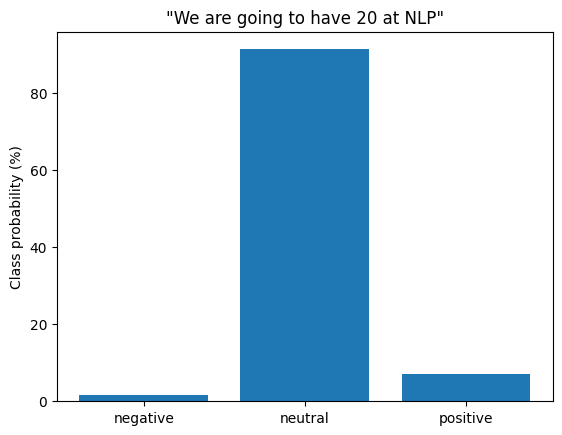

In [132]:
Title_news = "We are going to have 20 at NLP"
preds = classifier(Title_news, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f'"{Title_news}"')
plt.ylabel("Class probability (%)")
plt.show()

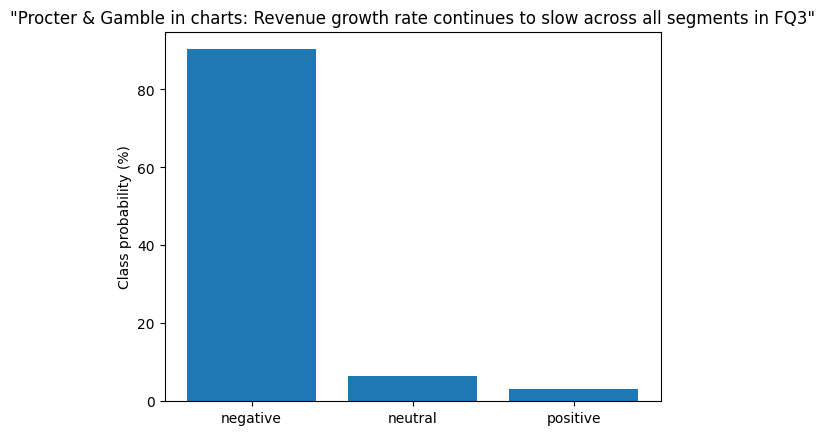

[[{'label': 'LABEL_0', 'score': 0.9029136896133423},
  {'label': 'LABEL_1', 'score': 0.065193310379982},
  {'label': 'LABEL_2', 'score': 0.03189298138022423}]]

In [105]:
Title_news = "Procter & Gamble in charts: Revenue growth rate continues to slow across all segments in FQ3"
preds = classifier(Title_news, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f'"{Title_news}"')
plt.ylabel("Class probability (%)")
plt.show()


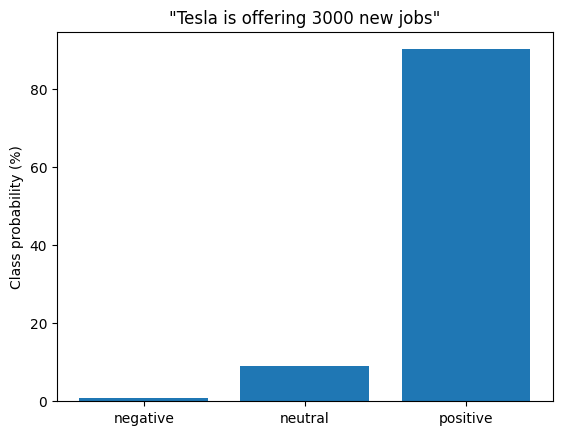

In [106]:
Title_news = "Tesla is offering 3000 new jobs"
preds = classifier(Title_news, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f'"{Title_news}"')
plt.ylabel("Class probability (%)")
plt.show()

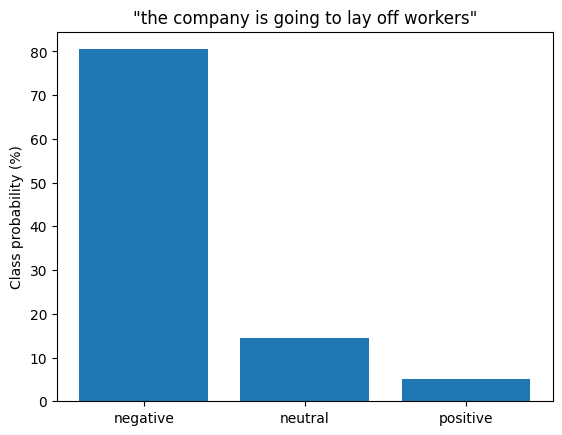

In [134]:
Title_news = "the company is going to lay off workers"
preds = classifier(Title_news, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f'"{Title_news}"')
plt.ylabel("Class probability (%)")
plt.show()

# Conclusion

- To begin with, we selected the dataset "Financial News Sentiment Analysis" as we found very interesting the idea of being able to predict possible market trends by analyzing the title or summaries of financial news. 

- In particular, this study could be used for Fundamental Analysis, which is a method of evaluating a security in an attempt to measure its intrinsic value, by examining related economic, financial, and other qualitative and quantitative factors. Fundamental analysts study anything that can affect the security's value, from macroeconomic factors such as the state of the economy and industry conditions to microeconomic factors like the effectiveness of the company's management. Therefore, this information can then be used to take a financial decision/position with respect to an asset.

- After carefully understanding the dataset, visualizing the distribution of data, tokens, words, unicity of features and many other characteristics, we divide our study in different approaches.

- We select 6 different models for the same dataset, from which, 4 are base models using Count Vectorizer, TF-IDF Vectorizer, Word2Vec and Doc2CV with a Logistic Regression predictor, and a single HuggingFace Transformer. The transformer non fine-tuned uses a Logistic Regression predictor as opposed to the fine-tuned version which uses the inherently neural network from the DistilBERT model.

- In terms of resuts, we achieved a logical and progressive improvement as we were considering more complex and expressive models, starting from an accuracy of 60 % and finally, with the fine-tuned DistilBERT transformer, reaching an accuracy of 85 %.

- The complete results are the following:

1. Fine-tuned DistilBERT: 85%

2. CountVectorizer + logistic: 77%

3. TF-IDF Vectorizer + logistic: 76%

4. DistilBERT_extract_feature + logistic : 73%

5. Word2vec + logistic = 64%

6. Doc2CV + logistic= 60%